# METODOLOGIA BASEADA EM CIÊNCIA DE REDES PARA ANÁLISE DE COMUNIDADES EM REDES SOCIAIS COM GEOLOCALIZAÇÃO

## Autor: ERIC LEAL

### Detalhes do Projeto
Em desenvolvimento...



## Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
import networkx as nx
import matplotlib.pyplot as plt
import utm
import math
import geopandas as gpd
from libpysal.weights import Rook

from IPython.display import display, clear_output
from tqdm.contrib.concurrent import thread_map

import tweepy
import os
from dotenv import load_dotenv
from shapely import geometry

# Required Libraries
from tqdm import tqdm as tqdmBasic

from sklearn.cluster import KMeans
import seaborn as sns; sns.set_theme()

## Configurando a API

In [ ]:
# Load the .env file
load_dotenv()

# Get the keys from the .env file
consumer_key = os.environ.get('TWITTER_API_KEY')
consumer_secret = os.environ.get('TWITTER_API_KEY_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
bearer_token = os.environ.get('TWITTER_BEARER_TOKEN')

# Authenticate with the twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Create the API object
api = tweepy.API(auth, wait_on_rate_limit=True)

## Carregando dados existententes caso existam

In [2]:
# Dicionario a ser preenchido com chaves sendo o author_id e os valores sendo o username
if os.path.exists(r'E://Dict_Author_Id_to_Username.json'):
    with open(r'E://Dict_Author_Id_to_Username.json', 'r') as fp:
        author_id_to_username = json.load(fp)
        print(f"Foram carregadas {len(author_id_to_username)} chaves do arquivo JSON")
else:
    author_id_to_username = {}

Foram carregadas 181528 chaves do arquivo JSON


In [3]:
df_mean = pd.read_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=None)
df_mean.columns = ["username", "mean_lat", "mean_lon", "median_lat", "median_lon", "mean_X", "mean_Y", "median_X", "median_Y"]
df_mean.head()

C:\Users\Cliente\AppData\Local\Temp\ipykernel_8100\2368035411.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mean = pd.read_csv(r"E:/DataFrameUsernameMeansMedians.csv", sep=";", header=None)


,username,mean_lat,mean_lon,median_lat,median_lon,mean_X,mean_Y,median_X,median_Y
0,username,mean_lat,mean_lon,median_lat,median_lon,mean_X,mean_Y,median_X,median_Y
1,Manuela_Lagoa,38.7,-9.18333333,38.7,-9.18333333,484058.0201695964,4283502.065548434,484058.0201695964,4283502.065548434
2,oblogdoedinho,38.72556305044776,-9.150001534925371,38.72556305,-9.15000153,486961.0744357934,4286333.415443861,486961.0748638524,4286333.415393474
3,noventaradio,38.86226743322353,-9.065096915696257,38.86485962,-9.06072863,494352.23164528405,4301494.446264396,494731.4127623029,4301781.836199852
4,object82,38.75138141069397,-9.188555476450512,38.7167,-9.1569,483615.65982184716,4289204.575585471,486359.7383995273,4285350.924191058


In [4]:
dfTopAuthorsProjected = pd.read_csv("E://TopAuthorsProjected.csv")

In [25]:
with open(r'E:/dictMentions_locations.json', 'r') as f:
    dictMentions = json.load(f)

# Print the dictionary
print(dictMentions)

{'MaurelioFama': [], 'nosuchuser': ['Moniz1904', 'helderrod', 'bossito', 'dhorta8', 'claudiof', 'martinezwall', 'Wonderm00n', 'ornitourindo', 'fhf', 'GoncaloPCruz', 'p_ribeiro', 'BaiaVieira', 'troublemaker_86', 'chartersazevedo', 'Fillip07', 'Correia_1904', 'jonasnuts', 'ZorGabor', 'javard0n', 'Lopesco', 'goncalocvale', 'Zeavy', 'Loira', 'clcortez', 'naotenhoestudos', 'ptdatabase', 'enfermeira_a', 'Bringer_GC', 'BrunoFigueiredo', 'TrapDoorCoir', 'camandro', 'Ohnoffris', 'paulo_pt', 'alieri', 'mtrevas', 'netriver', 'ozzywolf', 'RodBF', 'CurtaVermelha', 'filipecarvalho', 'pfl1976', 'jmgvostpt', 'SICNoticias', 'alvaromferro', 'mafaldamquerido', 'ndantas', 'fasf2000', 'F_ideias', 'sergio_mir', 'LuisFCorreia', 'LilianaValente', 'rsantos50', 'isacosta', 'nquina', 'iwearagasmask', 'ManuelReis', 'vazalmeida', 'davipt', 'sup3rfm', 'abreu', 'anti_tretas', 'Mmacedo_tweets', 'geo_ph', '1gajasemnick', 'Khlopomanstvo', 'VascoDaGamba_XV', 'Corpodormente', 'vidademigalhas', 'karlus', 'Ruben_M', 'aussi

In [5]:
grafo_twitter = nx.read_edgelist("D:\\Documentos\\data_and_code\\all_data_lisbon\\graphWithCoords.txt", create_using=nx.DiGraph())

## Carregando métodos

In [5]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

In [6]:
def load_jsonl(input_path) -> list:
    """
    Read list of objects from a JSON lines file.
    """
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

In [7]:
def dataframe_standartization(data_frame: pd.DataFrame, columns: list = []) -> pd.DataFrame:
    data_frame.drop(columns=columns, inplace=True)
    data_frame = data_frame.fillna(0)
    
    dictCoordByUser = {}

    for index, row in tqdmBasic(data_frame.iterrows(), total=data_frame.shape[0]):
        if row['username'] not in dictCoordByUser:
            dictCoordByUser[row['username']] = {
                'lat': [],
                'lon': []
            }        
            
        dictCoordByUser[row['username']]['lat'].append(row['lat'])
        dictCoordByUser[row['username']]['lon'].append(row['lon'])
        
    df_mean = pd.DataFrame(columns=["username", "mean_lat", "mean_lon", "median_lat", "median_lon"])

    for key in tqdmBasic(dictCoordByUser.keys()):
        df_mean = df_mean._append({
            "username": key,
            "mean_lat": np.mean(dictCoordByUser[key]['lat']),
            "mean_lon": np.mean(dictCoordByUser[key]['lon']),
            "median_lat": np.median(dictCoordByUser[key]['lat']),
            "median_lon": np.median(dictCoordByUser[key]['lon'])
        }, ignore_index=True)
        
    return df_mean

In [8]:
def gera_dict_mentions_by_user(data_frame: pd.DataFrame, data_frame2:pd.DataFrame = None,  mentions_unicas = True) -> dict:
    if data_frame2 is not None:
        mentions_usuario = {}
        
        for index, row in tqdmBasic(data_frame2.iterrows(), total=data_frame2.shape[0]):
            if row['username'] not in mentions_usuario:
                mentions_usuario[row['username']] = [row_base[0]['username'] for row_base in data_frame[data_frame['username'] == row['username']]['entities_mentions'].tolist() 
                                                     if row_base is not None]    
    else:
        data_editado = data_frame['entities_mentions']
        data_editado.dropna(inplace=True)
        # dataEditado.reset_index(drop=True, inplace=True)
        data_editado = data_editado.to_frame()
        
        mentions_usuario = {}

        # Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
            
        for mention in tqdmBasic(data_editado.itertuples(), total=data_editado.shape[0]):
            usuarios_mencionados = []
            
            coluna = 'author_id' #'username' if data_frame['username'].at[mention.Index] != '' else 'author_id'
            
            if data_frame[coluna].at[mention.Index] not in mentions_usuario:
                mentions_usuario[data_frame[coluna].at[mention.Index]] = []
                
            for usuario in mention[1]:
                usuarios_mencionados.append(usuario['username'])
                mentions_usuario[data_frame[coluna].at[mention.Index]].extend(usuarios_mencionados)
        
    if mentions_unicas:
        mentions_usuario = {k: list(dict.fromkeys(v)) for k, v in mentions_usuario.items()}
        
    return mentions_usuario

In [9]:
def geraDictLinkTweets(data_frame) -> list:
    dataEditado = data_frame['entities_urls']
    dataEditado.dropna(inplace=True)
    # dataEditado.reset_index(drop=True, inplace=True)
    dataEditado = dataEditado.to_frame()
    
    linksTweets = {}

    # Percorrendo teste1 e adicionando os usernames no dicionário usando o id do usuário como chave
        
    contador = 1
    for link in dataEditado.itertuples():
        print(f"Link {contador} de {dataEditado.shape[0]}")
        
        linksTweet = []
        if data_frame['author_id'].at[link.Index] not in linksTweets:
            linksTweets[data_frame['author_id'].at[link.Index]] = []
            
        for linkTweet in link[1]:
            linksTweet.append(linkTweet['expanded_url'])
            linksTweets[data_frame['author_id'].at[link.Index]].extend(linksTweet)
        contador += 1
        
    return linksTweets

In [10]:
def returnMediaDictListas(dict : dict) -> float:
    soma = 0
    for key in dict:
        soma += len(dict[key])
    return soma/len(dict)

In [11]:
def get_username(author_id: str):
    """Recupera o username do usuário a partir do author_id e atualiza o dicionário author_id_to_username

    Args:
        author_id: O id do usuário 
    """
    if author_id in author_id_to_username.keys():
        return
    
    author_id_to_username[author_id] = ''
    try:
        user = api.get_user(user_id=author_id)  
        author_id_to_username[author_id] = user.screen_name
    except:
        pass

In [12]:
def returnDataFrameWithUsernames(dataFrame : pd.DataFrame) -> pd.DataFrame:      
    dataFrame['username'] = ''
    
    thread_map(get_username, [id for id in dataFrame['author_id']], max_workers=16, total=dataFrame.shape[0])
        
    for index, row in dataFrame.iterrows():
        dataFrame['username'].at[index] = author_id_to_username[row['author_id']]
    
    return dataFrame

In [13]:
def degree_histogram_directed(G, in_degree=False, out_degree=False):
    """Return a list of the frequency of each degree value.

    Parameters
    ----------
    G : Networkx graph
       A graph
    in_degree : bool
    out_degree : bool

    Returns
    -------
    hist : list
       A list of frequencies of degrees.
       The degree values are the index in the list.

    Notes
    -----
    Note: the bins are width one, hence len(list) can be large
    (Order(number_of_edges))
    """
    nodes = G.nodes()
    if in_degree:
        in_degree = dict(G.in_degree())
        degseq=[in_degree.get(k,0) for k in nodes]
    elif out_degree:
        out_degree = dict(G.out_degree())
        degseq=[out_degree.get(k,0) for k in nodes]
    else:
        degseq=[v for k, v in G.degree()]
    dmax=max(degseq)+1
    freq= [ 0 for d in range(dmax) ]
    for d in degseq:
        freq[d] += 1
    return freq

In [14]:
def _export_dictionary(dict : dict, path : str = 'E://', file_name : str = 'dict.json'):
    """Exporta um dicionário para um arquivo JSON

    Args:
        dict (dict): dicionário a ser exportado
        path (str, optional): Caminho do arquivo de saída. Defaults to ''.
        file_name (str, optional): Nome do arquivo de saída. Defaults to 'dict.json'.
    """                
    with open(f"{path}{file_name}", 'w') as f:
        json.dump(dict, f)

In [15]:
def processRawData(data : dict | list[dict]) -> pd.DataFrame:
    data_frame = json_normalize(data,record_path = ['data'], sep = '_', errors ='ignore')
        
    data_frame['lat'] = data_frame['geo_coordinates_coordinates'].str.get(1)
    data_frame['lon'] = data_frame['geo_coordinates_coordinates'].str.get(0)

    #cleaning fields that will not be used
    try:
        # del data_frame['entities_mentions']
        del data_frame['context_annotations']
        # del data_frame['entities_urls']
        # del data_frame['entities_cashtags']
        del data_frame['withheld_copyright']
        del data_frame['withheld_country_codes']
        del data_frame['withheld_scope']
    except:
        pass
    
    return data_frame

In [16]:
def process_file(file: str) -> pd.DataFrame:
    """Processa um arquivo JSONL e retorna um dataframe

    Args:
        file (str): Caminho do arquivo JSONL

    Returns:
        pd.DataFrame: Dataframe com os dados do arquivo JSONL
    """
    print(f"Processando arquivo {file}")
    df = json_normalize(load_jsonl(file), sep='_', errors='ignore')
    return df

In [17]:
def convert_to_utm(df: pd.DataFrame, columnLat: str = "latitude", columnLon: str = "longitude", outColumnX: str = "x", outColumnY: str = "y") -> pd.DataFrame:
  """Converte as coordenadas de latitude e longitude para UTM zona 29.

  Args:
      df (pd.DataFrame): Dataframe com as coordenadas de latitude e longitude.
      columnLat (str, optional): Coluna que contém a latitude. Defaults to "latitude".
      columnLon (str, optional): Coluna que contém a longitude. Defaults to "longitude".
      outColumnX (str, optional): Coluna saída em UTM para o eixo X. Defaults to "x".
      outColumnY (str, optional): Coluna saída em UTM para o eixo Y. Defaults to "y".

  Returns:
      pd.DataFrame: Dataframe atualizado com as coordendas em UTM.
  """
  # Obtém as coordenadas de latitude e longitude.

  lat = df[columnLat].values
  lon = df[columnLon].values

  # Converte para UTM.

  easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)

  # Adiciona as colunas `mean_X` e `mean_Y` ao dataframe.

  df[outColumnX] = easting
  df[outColumnY] = northing

  return df

In [18]:
def get_expanded_urls(row):
    """
    Retorna uma lista com as URLs expandidas do tweet.

    Args:
        row: Uma linha do dataframe.

    Returns:
        Uma lista com as URLs expandidas do tweet.
    """

    if row['entities_urls']:
        expanded_urls = [url['expanded_url'] for url in row['entities_urls']]
    else:
        expanded_urls = []
    return expanded_urls

In [19]:
def associateNodes(row):
    G = nx.DiGraph()
    vertex = row['username'] if row['username'] != '' else row['author_id']
    
    if vertex not in G.nodes():
        G.add_node(vertex)
        
    if row['entities_mentions']:
        for mention in row['entities_mentions']:
            mention_username = mention['username']
            if mention_username not in G.nodes():
                G.add_node(mention_username)
            G.add_edge(vertex, mention_username)
    
    return G

In [20]:
def calculateDistance(xP1: float, yP1: float, xP2: float, yP2: float):
    P1 = [xP1, yP1]
    P2 = [xP2, yP2]
    
    return math.dist(P1, P2)

In [21]:
def calculateDistances(graph, generalizationLimit = None):
  nodes_with_median = [node for node in graph.nodes if "median_X" in graph.nodes[node]]
  
  print(f"Existem {len(nodes_with_median)} nós com mediana.")
  
  distances = {}
  
  for node in tqdmBasic(nodes_with_median):
    for other_node in nodes_with_median:
        if node == other_node:
            continue
        
        # print(f"Calculando distância entre {node} e {other_node}")
        
        distance = calculateDistance(
            graph.nodes[node]["median_X"], graph.nodes[node]["median_Y"], graph.nodes[other_node]["median_X"], graph.nodes[other_node]["median_Y"]
        )
        if generalizationLimit is not None:
            generaralized_distance = int(distance//generalizationLimit)
            if generaralized_distance not in distances.keys():
                distances[generaralized_distance] = 1
            else:
                distances[generaralized_distance] += 1
        else:
            if distance not in distances.keys():
                distances[distance] = 1
            else:
                distances[distance] += 1
            
        # distancesFromNode[node].append(distance)
  
  
  return distances

In [22]:
def plotScatterEmpyricalComplementarDistribution(distances, output_path: str = 'E://', output_file_name: str = 'empyrical_complementar_distribution.png', show: bool = False, log: bool = False):
    """Plota o gráfico de dispersão da distribuição empírica complementar.

    Args:
        distances (list): Lista com as distâncias.
        output_path (str): Caminho de saída do arquivo.
        output_file_name (str): Nome do arquivo de saída.
        show (bool): Se o gráfico deve ser exibido.
    """    
    # sort the distances

    # calculate the probability of each distance
    if isinstance(distances, dict):
        keys_in_order = sorted(distances.keys())
        length_distances = sum(distances.values())
        dist = 1
        prob = []
        print(f"keys_in_order: {keys_in_order}")
        print(f"length_distances: {length_distances}")
        
        distances_list = [key for key, value in distances.items() for _ in tqdmBasic(range(value))]
        n = len(distances_list)
        prob = [1 - (i+1)/n for i in tqdmBasic(range(0,n))]
                    
        distances = list(distances.keys())
        
    else:
        distances.sort()
        if log == True:
            prob = [np.log10(1 - (i/len(distances))) for i in tqdmBasic(range(len(distances)), desc="Calculando probabilidade")]
        else:
            prob = [1 - (i/len(distances)) for i in tqdmBasic(range(len(distances)))]
            
    print(type(prob))

    # plot the scatter graph
    plt.figure(figsize=(180, 120))
    plt.scatter(distances, prob)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel("Distância")
    plt.ylabel("Probabilidade")
    plt.savefig(f"{output_path}{output_file_name}", dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
       

## Gerando o grafo

In [23]:
gdf_wgs84 = gpd.read_file(r"C:\Users\Cliente\OneDrive\UNIRIO\TCC\GPK\Seccao_Area_de_Interesse.shp")

# gdf_wgs84.head()

In [24]:
gdf_wgs84 = gdf_wgs84.to_crs("EPSG:4326")

In [29]:
dataFrameComUsernames = json_normalize(load_jsonl(r'D:\\Documentos\\data_and_code\\all_data_lisbon\\dataWithUserNames.jsonl'), sep = '_', errors ='ignore') 

Loaded 3454314 records from D:\\Documentos\\data_and_code\\all_data_lisbon\\dataWithUserNames.jsonl


In [32]:
dataFrameComUsernames2 = dataframe_standartization(dataFrameComUsernames)

  0%|          | 0/57922 [00:00<?, ?it/s]C:\Users\Cliente\AppData\Local\Temp\ipykernel_8100\486796682.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_mean = df_mean._append({
100%|██████████| 57922/57922 [01:09<00:00, 830.28it/s] 


In [43]:
dataFrameComUsernames2.head()

,username,mean_lat,mean_lon,median_lat,median_lon
0,MaurelioFama,38.692092,-9.353893,38.692092,-9.353893
1,nosuchuser,38.812252,-9.160108,38.817108,-9.160068
2,arocha90,38.766144,-9.248321,38.765415,-9.255650
3,ruibandeiraa,38.695792,-9.173260,38.695792,-9.173260
4,Ricardoshisha,38.741702,-9.261545,38.741702,-9.261545


In [44]:
dictMentions = gera_dict_mentions_by_user(dataFrameComUsernames, data_frame2=dataFrameComUsernames2)

100%|██████████| 57922/57922 [7:25:59<00:00,  2.16it/s]  


In [45]:
_export_dictionary(dictMentions, 'E://', 'dictMentions_locations.json')

In [27]:
dictMentions['giradissotwanny']

['meeldrc', 'DosSorrisos', 'MiguelBerro', 'LuanaMfr']

In [34]:
gdf_users = gpd.read_file(r"E:\Usernames_Com_Coordenadas_Localidade.csv")
gdf_users['geometry'] = gdf_users.apply(lambda x: geometry.Point(x['mean_lon'], x['mean_lat']), axis=1)



In [35]:
grafo_twitter = nx.DiGraph()
grafo_fluxo = nx.DiGraph()
arestas_fluxo_inexistentes = []

for index, row in tqdmBasic(gdf_users.iterrows(), total=gdf_users.shape[0]):
    vertex = row['username']
    
    if vertex not in grafo_twitter.nodes():
        grafo_twitter.add_node(vertex)
        
    region_source = gdf_wgs84[gdf_wgs84.contains(geometry.Point(float(row['median_lon']), float(row['median_lat'])))]['DTMNFRSEC2']
    if not region_source.empty:
        nx.set_node_attributes(grafo_twitter, {vertex: {"region": region_source.values[0]}})
    
    if vertex not in dictMentions.keys():
        arestas_fluxo_inexistentes.append(vertex)
        continue
        
    for mention in dictMentions[row['username']]:
        if mention not in grafo_twitter.nodes():
            grafo_twitter.add_node(mention)
        grafo_twitter.add_edge(vertex, mention)
              
        mentioned_person = gdf_users[gdf_users['username'] == mention]
        
        try:
            region_target = gdf_wgs84[gdf_wgs84.contains(geometry.Point(mentioned_person['mean_lon'].values[0], mentioned_person['mean_lat'].values[0]))]['DTMNFRSEC2']
            if region_source.values[0] == region_target.values[0]:
                continue
            
            if grafo_fluxo.has_edge(region_source.values[0], region_target.values[0]):
                grafo_fluxo[region_source.values[0]][region_target.values[0]]['weight'] += 1
            else:
                grafo_fluxo.add_edge(region_source.values[0], region_target.values[0], weight=1)
        except IndexError:
            arestas_fluxo_inexistentes.append((vertex, mention))
            

100%|██████████| 116088/116088 [46:34<00:00, 41.54it/s]  


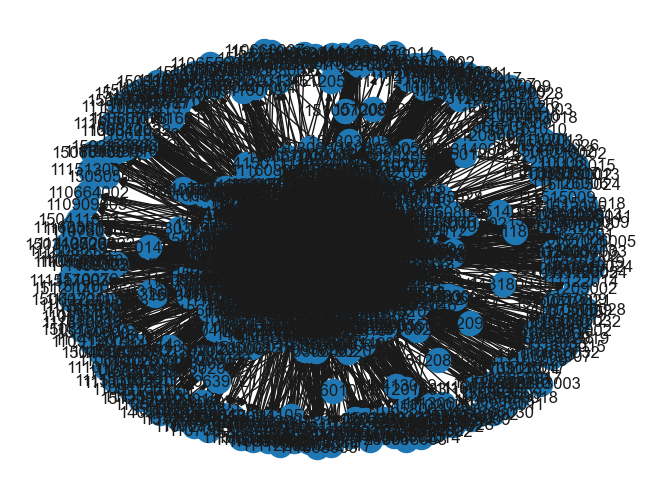

In [ ]:
grafo_regioes = nx.Graph()

for index, row in gdf_wgs84.iterrows():
    vertex = row['DTMNFRSEC2']
    adjacent_regions = gdf_wgs84[gdf_wgs84.geometry.touches(row['geometry'])]['DTMNFRSEC2']
    
    for adjacent_region in adjacent_regions:
        grafo_regioes.add_edge(vertex, adjacent_region)
    